In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Initial Lead Score Prediction (Data Within 24H of Signup)

In [28]:
%%bigquery model_evaluation --params $params
select * from 
ML.EVALUATE(MODEL `lead_scoring_model.lead_score_model_top_features_DNN`,
           (select  (case when clv_d_14 > 0 then 1 else 0 end) as label, * from `business-intelligence-240201.lead_scoring_model.train_data_with_email_frequency`
           where date_joined >= DATE_ADD(CURRENT_DATE(), INTERVAL -4 WEEK)
           and date_joined < DATE_ADD(CURRENT_DATE(), INTERVAL -2 WEEK)
           )
           ,  STRUCT(0.25) )

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.21rows/s]


In [29]:
model_evaluation

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.480429,0.751333,0.778926,0.58609,0.355844,0.849914


In [30]:
%%bigquery confusion_matrix
select * from 
ML.CONFUSION_MATRIX(MODEL `lead_scoring_model.lead_score_model_top_features_DNN`,
           (select  (case when clv_d_14 > 0 then 1 else 0 end) as label, * from `business-intelligence-240201.lead_scoring_model.train_data_with_email_frequency`
           where date_joined >= DATE_ADD(CURRENT_DATE(), INTERVAL -4 WEEK)
           and date_joined < DATE_ADD(CURRENT_DATE(), INTERVAL -2 WEEK)
           )
           ,  STRUCT(0.25) )

Downloading: 100%|██████████| 2/2 [00:00<00:00,  2.45rows/s]


In [31]:
confusion_matrix

,expected_label,_0,_1
0,0,31383,8535
1,1,2612,7892


In [32]:
%%bigquery feature_importance
SELECT
  *
FROM
  ML.FEATURE_IMPORTANCE(MODEL `lead_scoring_model.lead_score_model_top_features`)
 order by 3 desc 

Downloading: 100%|██████████| 20/20 [00:00<00:00, 24.51rows/s]


In [33]:
feature_importance

,feature,importance_weight,importance_gain,importance_cover
0,real_gender,22,1717.790399,44107.773818
1,value_inserted_statuses,126,165.503821,7302.704992
2,session_count,156,80.524845,8349.218867
3,has_mt5,58,67.709587,6949.407910
4,mt5_first_pnl,24,23.200404,13710.996750
5,real_aml_risk_classification,6,22.575067,6857.850000
6,traded_markets,30,22.400967,8388.779400
7,number_of_inserted_documents,66,18.514081,1143.059876
8,countd_clientid,62,13.378148,3737.256320
9,real_age_in_decade,28,13.005413,4531.326440


### Short Summary
We managed to archieve 0.685 PRC AUC, and 0.857 ROC AUC with only 24 hours of data.

## Lead Score Prediction (Data with 1Day,2Day,3Day,5Day,7Day,10Day,14Day)
Next, we want to predict lead score after N days of signup.  
Example Usages:  
i) Investigate drop off in the score after N days.  
ii) Investigate increase of score with engagement activity (eg:email engamement)

For the models, we are using cumulative activites for N days, for examaple, we get all 3 days of activities for 3Day model  
Hence to see drop off/increase, we can do substraction by score(T+1) - score (T)  
Eg: By doing Score_3_Day - Score_2_day, we can get the drop off/increase score of the user after day2, and before day4

In [35]:
%%bigquery df
select * from `lead_score_development.lead_score_N_days_prediction_with_14days_coef`

Downloading: 100%|██████████| 107954/107954 [00:01<00:00, 94172.98rows/s]


In [36]:
df.describe()

,probability_1d,probability_2d,probability_3d,probability_5d,probability_7d,probability_10d,probability_14d,binary_user_id,lifetime_deposit_usd,lifetime_withdrawal_usd,...,contract_count_deriv_real,client_win_count_bo_real,client_win_count_deriv_real,contract_count_bo_demo,contract_count_deriv_demo,client_win_count_bo_demo,client_win_count_deriv_demo,initial_lead_score,predicted_clv_30,predicted_clv_90
count,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,1.079540e+05,107954.000000,107954.000000,...,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,107647.000000,107647.000000,107647.000000
mean,0.083525,0.107090,0.123564,0.146327,0.162396,0.178587,0.192983,8.211409e+06,62.355219,21.765168,...,23.010134,41.254312,13.019962,267.674862,73.416122,163.937937,40.735267,0.223012,189.528362,268.596889
std,0.215759,0.247998,0.268159,0.293311,0.309332,0.324094,0.336638,3.483657e+04,1307.343722,287.481725,...,398.673982,429.507312,232.349890,2817.911389,1105.990678,1753.088082,616.414722,0.245653,89.849883,135.430668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.151239e+06,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011423,0.011423
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.181173e+06,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,105.752269,175.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,8.211440e+06,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,194.435638,237.511227
75%,0.040000,0.060000,0.070000,0.090000,0.120000,0.150000,0.180000,8.241585e+06,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340000,200.000000,260.017945
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.271698e+06,370204.255120,36506.000000,...,48739.000000,45553.000000,28318.000000,252845.000000,98053.000000,168334.000000,52573.000000,1.000000,4646.555532,4646.555532


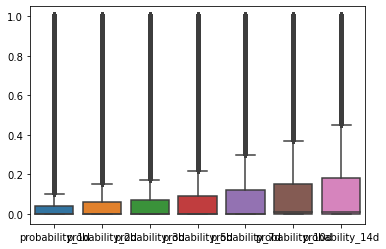

In [37]:
import seaborn as sns
sns.boxplot(data=df[['probability_1d','probability_2d','probability_3d','probability_5d','probability_7d','probability_10d','probability_14d']
              ]);

### Short Summary 
Avg Score is higher for more days, this is expected, as we are using cumulative activities

### Score Difference

In [39]:
df['score_diff_0d_1d'] = df['probability_1d']
df['score_diff_1d_2d'] = df['probability_2d'] - df['probability_1d']
df['score_diff_2d_3d'] = df['probability_3d'] - df['probability_2d']
df['score_diff_3d_5d'] = df['probability_5d'] - df['probability_3d']
df['score_diff_5d_7d'] = df['probability_7d'] - df['probability_5d']
df['score_diff_7d_10d'] = df['probability_10d'] - df['probability_7d']
df['score_diff_10d_14d'] = df['probability_14d'] - df['probability_10d']

In [40]:
df.columns

Index(['probability_1d', 'probability_2d', 'probability_3d', 'probability_5d',
       'probability_7d', 'probability_10d', 'probability_14d',
       'binary_user_id', 'signup_app_name', 'loginid_list', 'aff_status',
       'user_date_first_contact', 'user_date_joined', 'user_date_joined_real',
       'residence', 'email', 'email_verified', 'gclid_url',
       'has_social_signup', 'signup_device', 'utm_source', 'utm_medium',
       'utm_campaign', 'channel', 'subchannel', 'source', 'placement',
       'campaign_name', 'user_first_trade_date', 'user_first_deposit_date',
       'user_first_withdrawal_date', 'user_last_trade_date',
       'user_last_deposit_date', 'user_last_withdrawal_date', 'region',
       'payment_method', 'lifetime_deposit_usd', 'lifetime_withdrawal_usd',
       'lifetime_transfer_to_mt5_usd', 'lifetime_transfer_from_mt5_usd',
       'deal_count_mt5_real', 'client_win_count_mt5_real',
       'deal_count_mt5_demo', 'client_win_count_mt5_demo',
       'contract_count_bo

In [42]:
df[['score_diff_1d_2d', 'score_diff_2d_3d',
       'score_diff_3d_5d', 'score_diff_5d_7d', 'score_diff_7d_10d',
       'score_diff_10d_14d', 'score_diff_0d_1d']].head()

,score_diff_1d_2d,score_diff_2d_3d,score_diff_3d_5d,score_diff_5d_7d,score_diff_7d_10d,score_diff_10d_14d,score_diff_0d_1d
0,0.0,0.0,0.0,0.0,0.0,0.0,0.11
1,0.0,0.0,0.0,0.0,0.0,0.0,0.05
2,0.0,0.0,0.0,0.0,0.0,0.0,0.02
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [44]:
df[['score_diff_0d_1d','score_diff_1d_2d', 'score_diff_2d_3d',
       'score_diff_3d_5d', 'score_diff_5d_7d', 'score_diff_7d_10d',
       'score_diff_10d_14d']].describe()

,score_diff_0d_1d,score_diff_1d_2d,score_diff_2d_3d,score_diff_3d_5d,score_diff_5d_7d,score_diff_7d_10d,score_diff_10d_14d
count,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000,107954.000000
mean,0.083525,0.023565,0.016474,0.022763,0.016069,0.016191,0.014396
std,0.215759,0.115652,0.094638,0.113179,0.094384,0.097971,0.091598
min,0.000000,-0.900000,-0.820000,-0.890000,-0.920000,-0.870000,-0.850000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


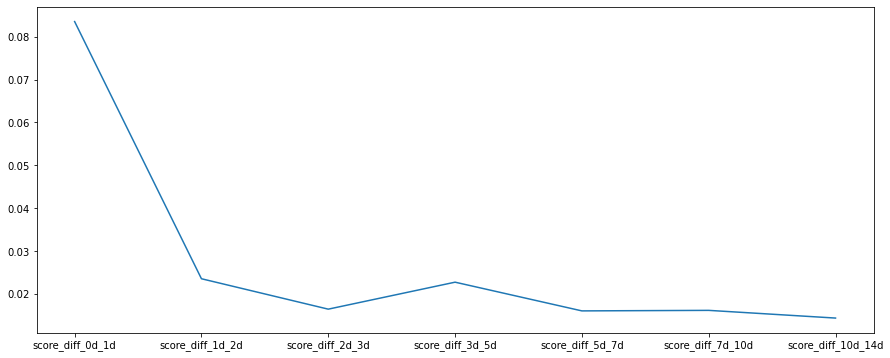

In [55]:
plt.figure(figsize=(15,6))
plt.plot(df[['score_diff_0d_1d','score_diff_1d_2d', 'score_diff_2d_3d',
       'score_diff_3d_5d', 'score_diff_5d_7d', 'score_diff_7d_10d',
       'score_diff_10d_14d']].mean())

### Short Summary 
Lead score dropped about 4 times after first day

## Conclusion  
-First day is the most important chance to convert our leads  
-We can estimate the effect of post-signup engament activity by calculating score difference